In [1]:
%pylab inline
import numpy as np
from astropy.table import Table
from astropy.io import fits as pf
import pylab as p
import matplotlib.pyplot as plt

# Machine Learning Kit:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# Cross-Validation:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

# Time:
from time import clock
#table read
from astropy.io import ascii

Populating the interactive namespace from numpy and matplotlib


In [30]:
def plot_fun(xaxis = np.arange(100), yaxis = np.arange(100), psym ='o',color = 'red', range_x= [2,4],range_y= [5,10],alpha = 0.9, lable_x = 'x-axis', lable_y = 'y-axis'):
# ):
    #figure(figsize=(6*1.3, 6*1.3))
    plt.plot(xaxis, yaxis, psym, color = color)
    plt.xlim(range_x)
    plt.ylim(range_y)    
    plt.xlabel(lable_x,fontsize=20)
    plt.ylabel(lable_y,fontsize=20)
    plt.grid(alpha = alpha)
    plt.show()
    return 

Reads Data file created for Photo_z and do basic consistency checks

In [2]:
data =ascii.read("Brownmocks_weighted_from_izt_gold_head.out")
print len(data), data.dtype

69782 [('col1', '<i8'), ('col2', '<f8'), ('col3', '<f8'), ('col4', '<i8'), ('col5', '<f8'), ('col6', '<f8'), ('col7', '<f8'), ('col8', '<f8'), ('col9', '<f8'), ('col10', '<f8'), ('col11', '<f8'), ('col12', '<f8'), ('col13', '<f8'), ('col14', '<f8'), ('col15', '<f8'), ('col16', '<f8')]


Read Magnitudes and Redshifts and do consistency checks.

In [79]:
u_mag, g_mag, r_mag, i_mag, z_mag , y_mag = data['col5'], data['col7'], data['col9'] , data['col11'], data['col13'], data['col15']

u_err, g_err,r_err, i_err, z_err, y_err = data['col6'], data['col8'], data['col10'], data['col12'], data['col14'], data['col16']  

z = data['col3']


0.001184 4.997716


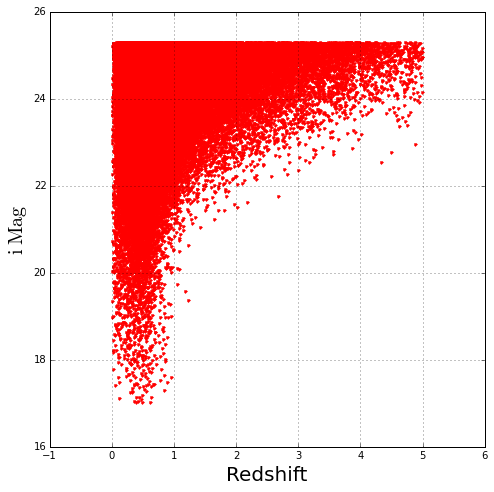

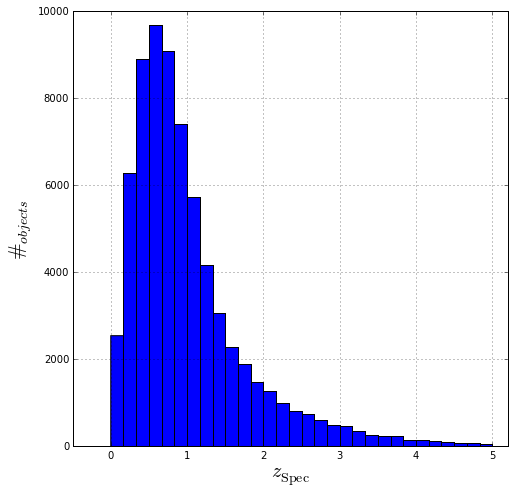

In [33]:
#some consistency checks.

print min(z),max(z)

# Plot of Photometric Redshift vs. i band mag
figure(1, figsize=(6*1.3, 6*1.3))
plot_fun(z, i_mag,'.','red',range_x= [-1.0, 6],range_y= [16.0, 26], alpha = 0.95, lable_y = '$\mathrm{i\ Mag}$',lable_x = 'Redshift' )

figure(2, figsize=(6*1.3, 6*1.3))
plt.hist(z,bins=30)
plt.ylim([0.0, 10000.0])
plt.xlim([-.50, 5.2])
# Plot Settings:
plt.xlabel('$z_{\mathrm{Spec}}$', fontsize = 20)
plt.ylabel('$\#_{objects}$', fontsize = 20)
plt.grid(alpha = 0.95)

#plt.legend(loc = 'best', fontsize = 20, handlelength = 0, numpoints = 1)
#plt.savefig('photo_z_corr_Vs_spec_z.pdf')

Assemble your training features and response variable. 

In [8]:
redshiftRn = z

# Training by magnitude

#XRn = np.column_stack((u_mag,g_mag,r_mag,i_mag,z_mag,y_mag))
#XRn = np.column_stack((g_mag,r_mag,i_mag,z_mag,y_mag))
#XRn = np.column_stack((u_mag,r_mag,i_mag,z_mag,y_mag))
#XRn = np.column_stack((u_mag,g_mag,i_mag,z_mag,y_mag))
#XRn = np.column_stack((u_mag,g_mag,r_mag,z_mag,y_mag))
#XRn = np.column_stack((u_mag,g_mag,r_mag,i_mag,y_mag))
#XRn = np.column_stack((u_mag,g_mag,r_mag,i_mag,z_mag))

# Training by color
XRn = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, i_mag, i_mag-z_mag, z_mag-y_mag))
#XRn = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, i_mag-z_mag, y_mag))
#XRn_pt = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, i_mag, i_mag-z_mag, z_mag-(y_mag-0.1)))

print len(redshiftRn), len(XRn)

69782 69782


In order to identify the optimal values for the Random Forest Regressor parameters we plot the average of the Cross-Validation score (adopted as the Standard Deviation) as a function of both 'n_estimators' ("number of trees" in the Random Forest) and 'max_depth' (maximum depth of the Random Forest "trees"). The optimal values for the parameters are the ones associated with the minimum of "score surface".


Define a range for control variables, 'depth of decision trees', 'number of estimators' and 'the number of partition in data'. 'KFold' splits the data into train and test sets. Below we use a nfold split by setting 'n_folds' = nfolds

In [29]:
mdepth = np.arange(2,30,2)
scores_std = np.zeros((nfolds, len(mdepth)))
scores_mad = np.zeros((nfolds, len(mdepth)))
scores_outl = np.zeros((nfolds, len(mdepth)))

# <<< Cross-Validation Routine Begins >>>
start = clock()

# Initializes counter:
i = 0

for train, test in kf:
    X_train, X_test, y_train, y_test = XRn[train,:], XRn[test,:], redshiftRn[train], redshiftRn[test]
    
    # Loops over the possible values of 'max_depth', i.e., the maximum depth of the Random Forest "trees":
    for j in range(len(mdepth)):
        regression = RandomForestRegressor(n_estimators = 50, max_depth = mdepth[j], max_features =  max_features = 'auto')
        regression.fit(X_train, y_train)
        # Computes the 'Standard Deviation for Error Assessment' as fitting score:
        scores_std[i,j] = np.std((regression.predict(X_test) - y_test)/(1 + y_test), ddof = 1)
        scores_mad[i,j] = np.median(np.abs((regression.predict(X_test) - np.median(y_test))/(1 + y_test)))/0.6745
        scores_outl[i,j] = np.sum(((regression.predict(X_test) - y_test)/(1 + y_test) > 0.15).astype('int'))*100/float(len(redshiftRn))
        
    # Add to counter:
    #print i
    i = i + 1

# <<< End of Cross-Validation Routine >>>
end = clock()

print 'Elapsed Time for Cross-Validation: ', (end - start)/60.0, ' min'

0
1
2
3
4
5
6
7
8
9
Elapsed Time for Cross-Validation:  10.22502195  min


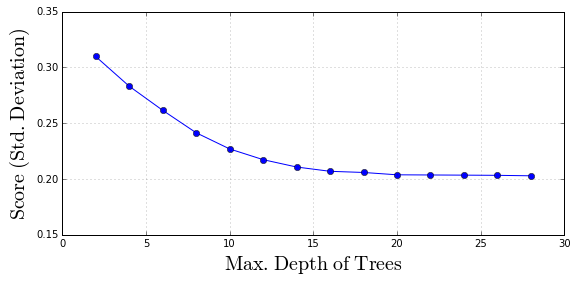

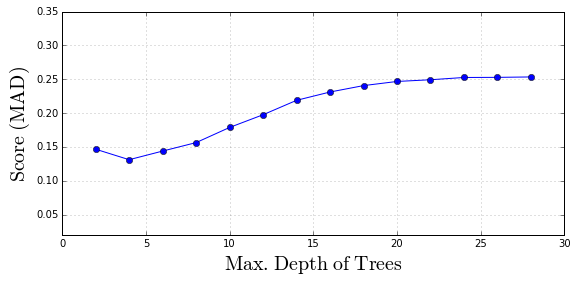

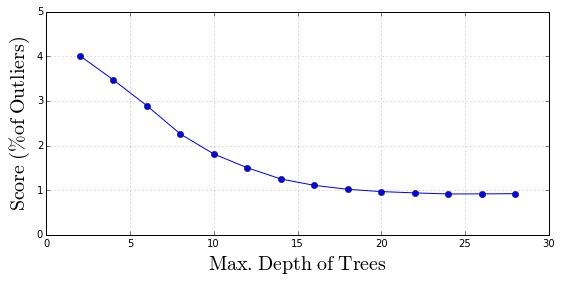

In [38]:
figure(1, figsize=(9, 4))
plot_fun(mdepth, scores_std.mean(axis = 0),'o-','blue',range_x= [0,max(mdepth)+2],range_y= [0.15,0.35], alpha = 0.5, lable_x = '$\mathrm{Max.\ Depth\ of\ Trees}$',lable_y = '$\mathrm{Score\ (Std.\ Deviation)}$' )

figure(2, figsize=(9, 4))
plot_fun(mdepth, scores_mad.mean(axis = 0),'o-','blue',range_x= [0,max(mdepth)+2],range_y= [0.02,0.35], alpha = 0.5, lable_x = '$\mathrm{Max.\ Depth\ of\ Trees}$',lable_y = '$\mathrm{Score\ (MAD)}$' )

figure(3, figsize=(9, 4))
plot_fun(mdepth, scores_outl.mean(axis = 0),'o-','blue',range_x= [0,max(mdepth)+2],range_y= [0,5], alpha = 0.5, lable_x = '$\mathrm{Max.\ Depth\ of\ Trees}$',lable_y = '$\mathrm{Score\ (\% of\ Outliers)}$' )


In [69]:
r_i= np.array(XRn[:,2]).reshape((len(XRn), 1))

print r_i.shape


(69782, 1)


In [70]:

ntrees = np.arange(1,71,5)

# The arrays 'scores' will store the Cross-Validation output:
scores_t = np.zeros((nfolds, len(ntrees)))

scores_std_t = np.zeros((nfolds, len(ntrees)))
scores_mad_t = np.zeros((nfolds, len(ntrees)))
scores_outl_t = np.zeros((nfolds, len(ntrees)))
i = 0

for train, test in kf:
    X_train, X_test, y_train, y_test = r_i[train,:], r_i[test,:], redshiftRn[train], redshiftRn[test]
    
    # Loops over the possible values of 'n_estimators', i.e., the "number of trees" in the Random Forest:
    for j in range(len(ntrees)):
        regression = RandomForestRegressor(n_estimators = ntrees[j])
        regression.fit(X_train, y_train)
        # Computes the 'Standard Deviation for Error Assessment' as fitting score:
        scores_std_t[i,j] = np.std((regression.predict(X_test) - y_test)/(1 + y_test), ddof = 1)
        scores_mad_t[i,j] = np.median(np.abs((regression.predict(X_test) - np.median(y_test))/(1 + y_test)))/0.6745
        scores_outl_t[i,j] = np.sum(((regression.predict(X_test) - y_test)/(1 + y_test) > 0.15).astype('int'))*100/float(len(redshiftRn))
    # Add to counter:
    print i
    i = i + 1

# <<< End of Cross-Validation Routine >>>
end = clock()
print 'Elapsed Time for Cross-Validation: ', (end - start)/60.0, ' min'

0
1
2
3
4
5
6
7
8
9
Elapsed Time for Cross-Validation:  35.0764722  min


Based on similar plots as above we can decide the optimum value of "number of estimators".

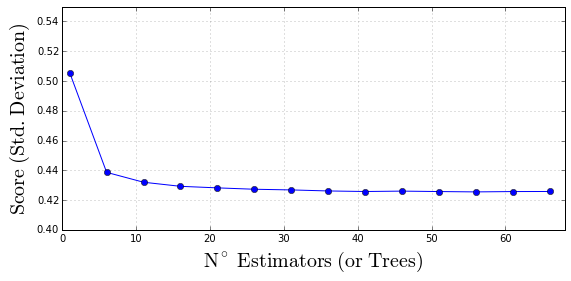

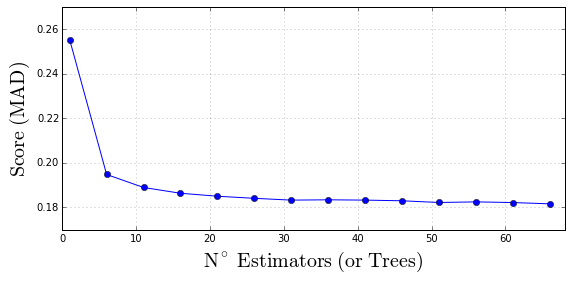

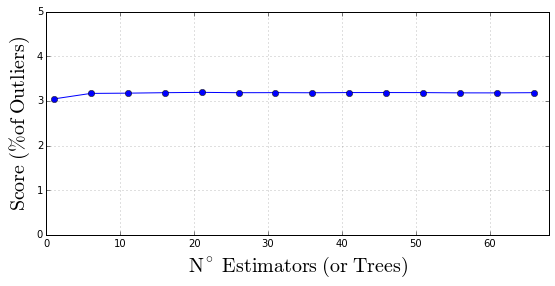

In [80]:
figure(1, figsize=(9, 4))
plot_fun(ntrees, scores_std_t.mean(axis = 0),'o-','blue',range_x= [0,max(ntrees)+2],range_y= [0.4,0.55], alpha = 0.5, lable_x = '$\mathrm{N^{\circ}}\ \mathrm{Estimators \ (or \ Trees)}$',lable_y = '$\mathrm{Score\ (Std.\ Deviation)}$' )

figure(2, figsize=(9, 4))
plot_fun(ntrees, scores_mad_t.mean(axis = 0),'o-','blue',range_x= [0,max(ntrees)+2],range_y= [0.17,0.27], alpha = 0.5, lable_x = '$\mathrm{N^{\circ}}\ \mathrm{Estimators \ (or \ Trees)}$',lable_y = '$\mathrm{Score\ (MAD)}$' )

figure(3, figsize=(9, 4))
plot_fun(ntrees, scores_outl_t.mean(axis = 0),'o-','blue',range_x= [0,max(ntrees)+2],range_y= [0,5], alpha = 0.5, lable_x = '$\mathrm{N^{\circ}}\ \mathrm{Estimators \ (or \ Trees)}$' ,lable_y = '$\mathrm{Score\ (\% of\ Outliers)}$' )

Based on above plots we can decide the optimum value of "number of estimators" and "depth of estimators". We use those values in our final model to train. 

In [81]:
XRn_train, XRn_test, redshiftRn_train, redshiftRn_test = train_test_split(XRn, redshiftRn, test_size = 0.20, train_size = 0.80)

regrn = RandomForestRegressor(n_estimators = 70, max_depth = 20, max_features = 'auto')
regrn.fit(XRn_train, redshiftRn_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=70, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

We are unable to plot the obtained regression in its entirety due to its multidimensional character. Alternatively, we 
can assess how good is the obtained regression by checking its score, given by: regrn.score()

We can also asses the other regular metrics that were used to optimize Random forest.

In [82]:
print 'Regression Score: ', regrn.score(XRn_test, redshiftRn_test)

std_result = np.std((regrn.predict(XRn_test) - redshiftRn_test)/(1 + redshiftRn_test), ddof=1)
print 'Standard Deviation: ', std_result

outl_result = np.sum(((regrn.predict(XRn_test) - redshiftRn_test)/(1 + redshiftRn_test) > 0.15).astype('int'))*100/float(len(redshiftRn_test))
print 'Percentage of Outliers: ', outl_result, '%'

mad_result = np.median(np.abs((regrn.predict(XRn_test) - (redshiftRn_test))/(1 + redshiftRn_test)))/0.6745
print 'Normalized MAD: ', mad_result

Regression Score:  0.809255459528
Standard Deviation:  0.201635760962
Percentage of Outliers:  6.03997993838 %
Normalized MAD:  0.0341080226432


In [83]:
z_test= redshiftRn_test 

photo_z = regrn.predict(XRn_test)
b = np.sqrt(np.mean((photo_z - z_test)**2/(1+z_test)**2))
print 'RMSD: ', b


no_outlier_test = (numpy.absolute((photo_z - z_test)/(1+z_test)) < 0.15)

b_no_outlier = np.sqrt(np.mean((photo_z[np.where(no_outlier_test == True)] - z_test[np.where(no_outlier_test == True)])**2/(1+z_test[np.where(no_outlier_test == True)])**2))
print len(photo_z[np.where(no_outlier_test == True)]), len(photo_z[np.where(no_outlier_test == False)])
print 1310.0/(12647+1310.0),b_no_outlier


RMSD:  0.203035227514
12583 1374
0.0938597119725 0.0431585417329


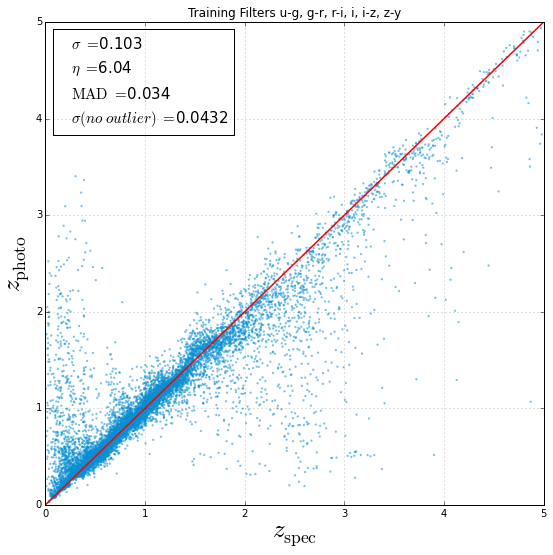

In [85]:
# Plot of Photometric Redshift vs. Spectroscopic Redshift

figure(figsize=(6*1.3, 6*1.3))

plt.plot(np.arange(0,5.4,0.05), np.arange(0,5.4,0.05), linewidth=1.5, color = 'red')
plt.scatter(redshiftRn_test, regrn.predict(XRn_test), facecolors='#088ED1', edgecolors='none', marker = '.', alpha=0.55)

plt.plot(0,0, label = '$\sigma \ = $'+str(round(b-.1,3)), color = 'white')
plt.plot(0,0, label = '$\eta \ = $'  +str(round(outl_result,3)), color = 'white')
plt.plot(0,0, label = '$\mathrm{MAD} \ = $'+str(round(mad_result,3)), color = 'white')
plt.plot(0,0, label = '$\sigma (no\ outlier)\ = $'  +str(round(b_no_outlier,4)), color = 'white')

# Axis limits:
plt.xlim([0.0, 5])
plt.ylim([0.0, 5])
        
# Plot Settings:
plt.title('Training Filters u-g, g-r, r-i, i, i-z, z-y')
plt.xlabel('$z_{\mathrm{spec}}$', fontsize = 25)
plt.ylabel('$z_{\mathrm{photo}}$', fontsize = 25)
plt.grid(alpha = 0.5)
plt.legend(loc = 'best', fontsize = 15, handlelength = 0, numpoints = 1)
plt.tight_layout()
#plt.savefig('A_new_LSST_photo_z_Vs_spec_z_u, u-g, g-r, r-i, i-z, z-y.jpg')


In [14]:
#numpy.savetxt('phot_z_y_0_1.txt', p_z_y_0_1, fmt='%.5e', delimiter=' ', newline='\n', header='del_m_y=-0.1', footer='', comments='# ')

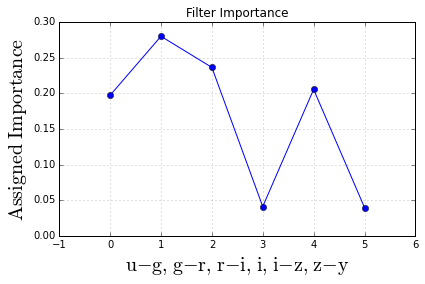

In [86]:
plt.plot(regrn.feature_importances_,marker='o')

# Plot Settings:
plt.title('Filter Importance')
plt.ylabel('$\mathrm{Assigned\ Importance}$', fontsize = 20)
plt.xlabel('$\mathrm{u-g,\ g-r,\ r-i,\ i, \ i-z,\ z-y}$', fontsize = 20)
plt.xlim(-1,6)
plt.ylim(0.0,0.30)
plt.grid(alpha = 0.5)

plt.tight_layout()
#plt.savefig('a_new_LSST_photo_z_importance_u, u-g, g-r, r-i, i-z, z-y.jpg')

In [87]:
print np.sum(regrn.feature_importances_)
print regrn.feature_importances_

1.0
[ 0.19724772  0.28006668  0.23638928  0.04109502  0.20550142  0.03969989]
